In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time

from util import *
from data_loader import * 
import scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset={}
dataname = ['brain9k','brain1k','PBMC8k','PBMC68k','brain2k','brain1.3m']
dataset['brain9k'] = load_10x_9k() ## 9k brain cells 
dataset['brain1k'] = load_10x_1k() ## 1k brain cells 
dataset['PBMC8k'] = load_10x_8k() ## 8k PBMC cells 
dataset['PBMC68k'] = load_10x_68k() ## 68k PBMC cells 
dataset['brain2k'] = load_10x_2k() ## 2k brain cells 
# dataset['brain1.3m'] = load_10x_1_3mil() ## 1.3 million brain cells 
dataset['PBMC4k'] = load_10x_4k()

# MSE consistency

In [4]:
M,M_ml,M_nsf,M_ml_nsf,gene_list,gene_list_nsf = {},{},{},{},{},{}
pdata = {}

for dname in dataset.keys():
    if dname=='brain1.3m': break
    print('## processing %s ...'%dname)
    print('# raw data: n_cell=%d, n_gene=%d'%(dataset[dname].shape[0],dataset[dname].shape[1]))
    temp = dataset[dname].copy()
#     sc.pp.filter_cells(temp, min_counts=0.5*temp.shape[1])
    gamma_c = sd.sf(temp,verbose=False)
    sc.pp.filter_genes(temp,min_counts=0.1*temp.shape[0])
    print('# after filtering: n_cell=%d, n_gene=%d'%(temp.shape[0],temp.shape[1]))
    pdata[dname] = temp
    M_,M_ml_,gene_list_ = sd.dd_moment_anndata(temp,gamma_c=gamma_c,verbose=False,k=4)
    M_nsf_,M_ml_nsf_,gene_list_nsf_ = sd.dd_moment_anndata(temp,gamma_c=None,verbose=False,k=4)
    
    M[dname],M_ml[dname],M_nsf[dname],M_ml_nsf[dname],gene_list[dname],gene_list_nsf[dname] = \
    M_,M_ml_,M_nsf_,M_ml_nsf_,gene_list_,gene_list_nsf_
    print('\n')
#     if dname=='PBMC8k': break

## processing brain9k ...
# raw data: n_cell=9128, n_gene=27998
# after filtering: n_cell=9128, n_gene=7578


## processing brain1k ...
# raw data: n_cell=931, n_gene=27998
# after filtering: n_cell=931, n_gene=8124


## processing PBMC8k ...
# raw data: n_cell=8381, n_gene=33694
# after filtering: n_cell=8381, n_gene=4329


## processing PBMC68k ...
# raw data: n_cell=68579, n_gene=32738
# after filtering: n_cell=68579, n_gene=1385


## processing brain2k ...
# raw data: n_cell=2022, n_gene=27998
# after filtering: n_cell=2022, n_gene=7060


## processing PBMC4k ...
# raw data: n_cell=4340, n_gene=33694
# after filtering: n_cell=4340, n_gene=4039




In [5]:
## change all the gene names to upper-case 
for gl in gene_list.keys():
    temp = gene_list[gl]
    for i in range(len(temp)):
        temp[i] = temp[i].upper()
    gene_list[gl] = temp
for gl in gene_list.keys():
    temp = gene_list_nsf[gl]
    for i in range(len(temp)):
        temp[i] = temp[i].upper()
    gene_list_nsf[gl] = temp

In [6]:
## MSE bound 
def param_cal(data):
    Nc,G = data.shape[0],data.shape[1]
    B = data.X.sum()
    Nr = B/Nc
    print('Nr=%0.2f, Nr_bar=%0.2f, Nc=%d, G=%d, B=%d'%(Nr,Nr/G,Nc,G,B))
    return Nr,Nc,G,B


def opt_alpha(M):
    M1,M2,M3,M4 = M[:,0],M[:,1],M[:,2],M[:,3]
    M2 = M2.clip(min=1e-4)
    var_x2 = M4 - M2**2       
    alpha_opt = np.sqrt((var_x2/M2**2).sum()/(2/M2).sum())        
    return alpha_opt

# M is the moments for lambda_cg
def opt_Nr_single(M):
    M1,M2,M3,M4 = M[:,0],M[:,1],M[:,2],M[:,3]
    var_x2 = (M4 - M2**2).clip(min=0)   
    alpha_opt = np.sqrt(var_x2/2/M2)
    return M1[var_x2>0]/alpha_opt[var_x2>0]


def bound_MSE(M,data,alpha,verbose=True,color='orange',label=None):
    Nr,Nc,B = param_cal(data_8k)
    M1,M2,M3,M4 = M[:,0],M[:,1],M[:,2],M[:,3]
    G = M1.shape[0]
    M2 = M2.clip(min=1e-4)
    var_x2 = M4 - M2**2    
    RMSE = var_x2/M2**2/alpha + 4*M3/M2**2 + alpha*2/M2
    RMSE = RMSE/Nc
    
    cv = np.sqrt( (M2-M1**2).clip(min=1e-4))/M1

    if verbose: 
        plt.title('alpha=%0.3f'%alpha)
#         plt.scatter(np.log10(M1.clip(min=1e-2)),np.log10(RMSE.clip(min=1e-6)),color=color,alpha=0.1,label=label)
        plt.scatter(np.log10(cv.clip(min=1e-4)),np.log10(RMSE.clip(min=1e-6)),color=color,alpha=0.1,label=label)
#         plt.scatter(cv.clip(min=1e-4),np.log10(RMSE.clip(min=1e-6)),color=color,alpha=0.1,label=label)
#         plt.xlabel('log mean')
        plt.xlabel('log10 cv')
        plt.ylabel('log10 RMSE')
        print('mean RMSE=%0.4f',RMSE.mean())
    return RMSE, cv


    

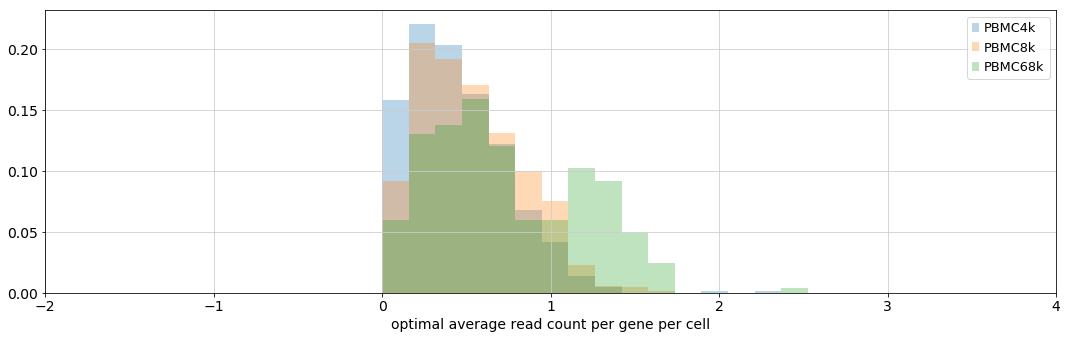

In [38]:
plt.figure(figsize=[18,5])
for dname in ['PBMC4k','PBMC8k','PBMC68k']:
    Nr_opt = opt_Nr_single(M_nsf[dname][M_nsf[dname][:,0]>0.5,:])
    temp = Nr_opt.shape[0]
    plt.hist(Nr_opt,bins=np.linspace(0,3,20),weights=1/temp*np.ones([temp]),alpha=0.3,label=dname)
plt.xlabel('optimal average read count per gene per cell')
plt.xlim([-2,4])
plt.legend()
plt.show()

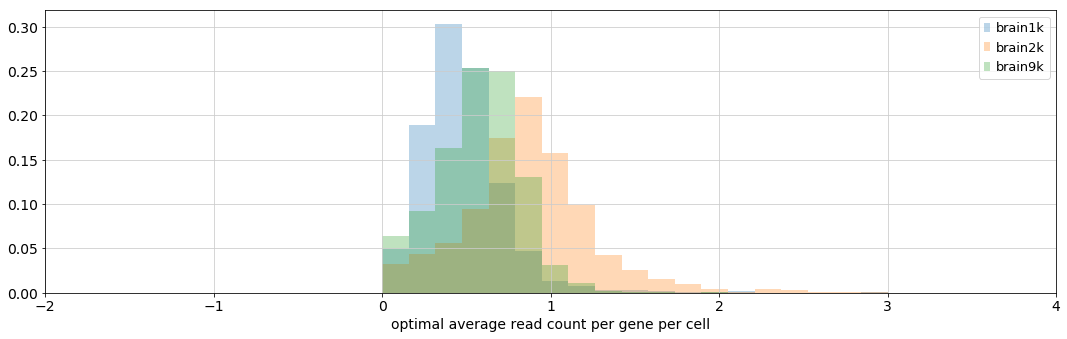

In [37]:
plt.figure(figsize=[18,5])
for dname in ['brain1k','brain2k','brain9k']:
    Nr_opt = opt_Nr_single(M_nsf[dname][M_nsf[dname][:,0]>0.5,:])
    temp = Nr_opt.shape[0]
    plt.hist(Nr_opt,bins=np.linspace(0,3,20),weights=1/temp*np.ones([temp]),alpha=0.3,label=dname)

plt.xlabel('optimal average read count per gene per cell')
plt.legend()
plt.xlim([-2,4])
plt.show()

In [39]:
## find the common genes 
gene_set = []
data_list = ['brain1k','brain2k','brain9k']
for gene in gene_list['brain1k']:
    if_skip=0
    for dname in data_list: 
        if gene in gene_list[dname]:
            temp = gene_list[dname].index(gene)
        else:
            if_skip=1
            break
        if M_ml_nsf[dname][temp,0]<0.5:
            if_skip=1
            break
    if if_skip==0:
        gene_set.append(gene)
print(len(gene_set))

idx={}
for dname in data_list:
    idx[dname]=[]
for gene in gene_set:
    #print('# %s'%gene)
    for dname in data_list:
        temp = gene_list[dname].index(gene)
        idx[dname].append(temp)
        #print('%s :%0.2f'%(dname,M_ml_nsf[dname][temp,0]))      
        
for dname in data_list:
    print('### %s'%dname)
    gene_idx = idx[dname]
    Nr,Nc,G,B = param_cal(pdata[dname][:,gene_idx])
    alpha_opt = opt_alpha(M_nsf[dname][gene_idx,:])
    print('alpha_opt=%0.2f, opt mean N_r=%0.2f, opt N_c=%d'%(alpha_opt,Nr/G/alpha_opt,Nc*alpha_opt))
    print('\n')  

2064
### brain1k
Nr=9270.70, Nr_bar=4.49, Nc=931, G=2064, B=8631018
alpha_opt=3.86, opt mean N_r=1.16, opt N_c=3593


### brain2k
Nr=6079.29, Nr_bar=2.95, Nc=2022, G=2064, B=12292326
alpha_opt=1.76, opt mean N_r=1.68, opt N_c=3554


### brain9k
Nr=5683.53, Nr_bar=2.75, Nc=9128, G=2064, B=51879292
alpha_opt=2.73, opt mean N_r=1.01, opt N_c=24920




In [40]:
## find the common genes 
gene_set = []
data_list = ['PBMC4k','PBMC8k','PBMC68k']
for gene in gene_list['PBMC4k']:
    if_skip=0
    for dname in data_list: 
        if gene in gene_list[dname]:
            temp = gene_list[dname].index(gene)
        else:
            if_skip=1
            break
        if M_ml_nsf[dname][temp,0]<0.5:
            if_skip=1
            break
    if if_skip==0:
        gene_set.append(gene)
print(len(gene_set))

idx={}
for dname in data_list:
    idx[dname]=[]
for gene in gene_set:
    #print('# %s'%gene)
    for dname in data_list:
        temp = gene_list[dname].index(gene)
        idx[dname].append(temp)
        #print('%s :%0.2f'%(dname,M_ml_nsf[dname][temp,0]))      
        
for dname in data_list:
    print('### %s'%dname)
    gene_idx = idx[dname]
    Nr,Nc,G,B = param_cal(pdata[dname][:,gene_idx])
    alpha_opt = opt_alpha(M_nsf[dname][gene_idx,:])
    print('alpha_opt=%0.2f, opt mean N_r=%0.2f, opt N_c=%d'%(alpha_opt,Nr/G/alpha_opt,Nc*alpha_opt))
    print('\n')  

279
### PBMC4k
Nr=2798.50, Nr_bar=10.03, Nc=4340, G=279, B=12145472
alpha_opt=6.48, opt mean N_r=1.55, opt N_c=28135


### PBMC8k
Nr=2950.24, Nr_bar=10.57, Nc=8381, G=279, B=24725940
alpha_opt=5.82, opt mean N_r=1.82, opt N_c=48751


### PBMC68k
Nr=943.24, Nr_bar=3.38, Nc=68579, G=279, B=64686312
alpha_opt=2.68, opt mean N_r=1.26, opt N_c=183897




In [83]:
for dname in pdata.keys():
    print('### %s'%dname)
    Nr,Nc,G,B = param_cal(pdata[dname])
    alpha_opt = opt_alpha(M_ml[dname])
    print(alpha_opt,Nr/G/alpha_opt,Nc*alpha_opt)
    print('\n')

### brain9k
Nr=5042.90, Nr_bar=4.24, Nc=9128, G=1188, B=46031628
2.1929745114128103 1.935667145849436 20017.471340176133


### brain1k
Nr=9049.75, Nr_bar=5.11, Nc=931, G=1770, B=8425316
1.252553306074694 4.081943917271296 1166.1271279555401


### PBMC8k
Nr=3290.79, Nr_bar=7.67, Nc=8381, G=429, B=27580132
6.374692960863473 1.2033277604790533 53426.30170499677


### PBMC68k
Nr=867.87, Nr_bar=5.20, Nc=68579, G=167, B=59517600
2.793268374008669 1.860480518893791 191559.55182114049


### brain2k
Nr=5471.33, Nr_bar=4.53, Nc=2022, G=1207, B=11063035
1.61245554747726 2.811241234226041 3260.38511699902


### brain1.3m
Nr=2992.44, Nr_bar=3.81, Nc=1306127, G=785, B=3908503296
2.29817979170156 1.658713644216424 3001714.6767957835


